In [75]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.exceptions import ConvergenceWarning

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning) 

start = time.perf_counter()

In [76]:
df = pd.read_csv('earl694412-infinite-matchhistory-3.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871 entries, 0 to 870
Data columns (total 47 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               871 non-null    object 
 1   SeasonNumber       871 non-null    int64  
 2   SeasonVersion      871 non-null    int64  
 3   Player             871 non-null    object 
 4   MatchId            871 non-null    object 
 5   Map                871 non-null    object 
 6   Category           871 non-null    object 
 7   Playlist           871 non-null    object 
 8   Input              871 non-null    object 
 9   Queue              871 non-null    object 
 10  PreCsr             871 non-null    int64  
 11  PostCsr            871 non-null    int64  
 12  Rank               871 non-null    int64  
 13  WasAtStart         871 non-null    int64  
 14  WasAtEnd           871 non-null    int64  
 15  WasInProgressJoin  871 non-null    int64  
 16  Mmr                2 non-n

In [77]:
# General Fixes+Additions
df['Date'] = pd.to_datetime(df['Date'])
df['LengthMinutes'] = df['LengthSeconds'] / 60
df.rename(columns={'TotalKills': 'Kills'}, inplace=True)
df['KillsBody'] = df['Kills'] - df['KillsGrenade'] - df['KillsHeadshot'] - df['KillsMelee'] - df['KillsPower']
# Ratios
df['DamageRatio'] = df['DamageDone'] / df['DamageTaken']
df['Damage/Kill'] = df['DamageDone'] / df['Kills']
df['Damage/KA'] = df['DamageDone'] / (df['Kills'] + df['Assists'])
# Per 10 Min
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['Shots/10Min'] = (df['ShotsFired'] / df['LengthMinutes']) * 10
# Excess
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']
# Kill Type
df['BodyPct'] = df['KillsBody'] / df['Kills'] *100
df['MeleePct'] = df['KillsMelee'] / df['Kills'] * 100
df['HSPct'] = df['KillsHeadshot'] / df['Kills'] * 100
df['GrenadePct'] = df['KillsGrenade'] / df['Kills'] * 100
df['PowerPct'] = df['KillsPower'] / df['Kills'] * 100



df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr', 'PreCsr', 'PostCsr', 'ShotsFired', 'AssistsEmp',
              'ShotsMissed', 'ShotsLanded', 'Betrayals', 'Suicides', 'WasAtStart', 'WasAtEnd', 'AssistsDriver',
              'Perfects', 'WasInProgressJoin', 'VehicleDestroys', 'VehicleHijacks', 'AssistsCallout',
              'LengthSeconds', 'Rank', 'SeasonNumber', 'SeasonVersion', 'Map'],axis=1)
df = df.drop(['KillsBody','KillsMelee', 'KillsGrenade', 'KillsHeadshot', 'KillsPower'], axis=1)
# df = df.drop(['Kills','Deaths', 'Assists', 'DamageDone', 'DamageTaken'], axis=1)
dfR = df[df['Playlist'] == 'Ranked Arena']
dfRR = dfR[dfR['Date']> '2023-01-01']
dfRR = dfRR[dfRR['Outcome'] != 'Draw']
dfRR = dfRR[dfRR['Outcome'] != 'Left']
dfRR['Outcome'] = dfRR['Outcome'].map({'Win': 1, 'Loss': 0})
dfRR = dfRR.drop(['Date', 'Category', 'Playlist'], axis=1)
dfRR = dfRR.dropna()
dfRR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 609 entries, 140 to 870
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Outcome         609 non-null    int64  
 1   Accuracy        609 non-null    float64
 2   DamageDone      609 non-null    int64  
 3   DamageTaken     609 non-null    int64  
 4   KD              609 non-null    float64
 5   KDA             609 non-null    float64
 6   Kills           609 non-null    int64  
 7   Deaths          609 non-null    int64  
 8   Assists         609 non-null    int64  
 9   MaxSpree        609 non-null    int64  
 10  ExpectedKills   609 non-null    float64
 11  ExpectedDeaths  609 non-null    float64
 12  Score           609 non-null    int64  
 13  Medals          609 non-null    int64  
 14  LengthMinutes   609 non-null    float64
 15  DamageRatio     609 non-null    float64
 16  Damage/Kill     609 non-null    float64
 17  Damage/KA       609 non-null    f

In [78]:
def cnt(df, col):
    count = df[col].count()
    return count
def sm(df, col):
    sum = df[col].sum()
    return sum
def avg(df, col, val=None):
    avg = round(sm(df, col) / cnt(df, col),val)
    return avg


In [79]:
corr_mtrx = dfRR.corr().abs()
print(corr_mtrx['Outcome'].sort_values(ascending=False))

Outcome           1.000000
Deaths/10Min      0.434927
DmgT/10Min        0.362316
Deaths            0.314770
KD                0.312146
Damage/KA         0.284343
KDA               0.284241
ExcessDeaths      0.263725
DamageTaken       0.250193
ExpectedDeaths    0.206631
Assists/10Min     0.189801
Damage/Kill       0.183034
Kills/10Min       0.144116
LengthMinutes     0.137380
DamageRatio       0.126117
Accuracy          0.113204
MaxSpree          0.112117
DamageDone        0.092292
Assists           0.061415
BodyPct           0.058745
HSPct             0.057941
Dmg/10Min         0.038685
ExpectedKills     0.036214
Score             0.035237
Kills             0.020860
GrenadePct        0.018550
Medals            0.018180
MeleePct          0.012959
ExcessKills       0.008014
PowerPct          0.004574
Shots/10Min       0.003605
Name: Outcome, dtype: float64


In [80]:
# dfRR.hist(bins=15, figsize=(16, 12))
# plt.tight_layout()
# plt.show()

In [81]:
dfRR.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Outcome,609.0,0.553366,0.497553,0.000000,0.000000,1.000000,1.000000,1.000000
Accuracy,609.0,52.051642,5.275050,36.800000,48.680000,52.100000,55.090000,80.560000
DamageDone,609.0,5245.958949,1832.318301,667.000000,3889.000000,5027.000000,6444.000000,12673.000000
DamageTaken,609.0,4472.172414,1550.002185,35.000000,3455.000000,4291.000000,5498.000000,9962.000000
KD,609.0,1.273120,0.763108,0.270000,0.860000,1.130000,1.450000,10.000000
KDA,609.0,4.528949,5.595590,-10.000000,0.660000,4.660000,8.000000,31.000000
Kills,609.0,14.574713,6.287892,1.000000,10.000000,14.000000,18.000000,40.000000
Deaths,609.0,12.898194,5.195153,0.000000,9.000000,12.000000,16.000000,32.000000
Assists,609.0,8.563218,4.262716,1.000000,6.000000,8.000000,11.000000,28.000000
MaxSpree,609.0,3.947455,1.554026,1.000000,3.000000,4.000000,5.000000,10.000000


In [82]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [83]:
# Define features (X) and target variable (y)
X = dfRR.drop('Outcome', axis=1) 
X = round(X,20)
y = dfRR['Outcome'] 

print(f'X Shape: {X.shape}')
print(f'Y Shape: {y.shape}')

X Shape: (609, 30)
Y Shape: (609,)


In [84]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=27)
print(f'X Train Shape: {X_train.shape}')
print(f'X Test Shape: {X_test.shape}')
# print(X_train.columns)
print(f'Y Train Mean: {round(y_train.mean(),3)}')
print(f'Y Test Mean: {round(y_test.mean(),3)}')

X Train Shape: (487, 30)
X Test Shape: (122, 30)
Y Train Mean: 0.554
Y Test Mean: 0.549


In [85]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Accuracy', 'ExpectedKills', 'ExpectedDeaths', 'KD', 
                                    'KDA', 'MaxSpree', 'Deaths', 'Assists', 'Kills', 'DamageDone', 
                                    'DamageTaken', 'Score', 'Medals', 'LengthMinutes', 
                                    'DamageRatio', 'Damage/Kill', 'Damage/KA', 
                                    'Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'Dmg/10Min',
                                    'DmgT/10Min', 'Shots/10Min', 'ExcessKills', 'ExcessDeaths',
                                    'BodyPct', 'MeleePct', 'HSPct', 'GrenadePct', 'PowerPct'])])

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the data
X_train_preprocessed = pipeline.fit_transform(X_train)
X_test_preprocessed = pipeline.transform(X_test)

# X_train_preprocessed.to_csv('X_train_preprocessed.csv')
# X_test_preprocessed.to_csv('X_test_preprocessed.csv')

print(f'X Train Processed Shape: {X_train_preprocessed.shape}')
print(f'X Train Shape: {X_train.shape}')
print(f'X Test Processed Shape: {X_test_preprocessed.shape}')

X Train Processed Shape: (487, 30)
X Train Shape: (487, 30)
X Test Processed Shape: (122, 30)


In [86]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, log_loss, classification_report, confusion_matrix
MSE_Histmean = mean_squared_error(y_test,np.full(y_test.shape,np.mean(y_train)))

def ResultsOut(model):
  y_pred = model.predict(X_test_preprocessed)
  # Calculate regression metrics
  acc = model.score(X_test_preprocessed, y_test)
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  rmse = mean_squared_error(y_test, y_pred, squared=False)
  r2 = r2_score(y_test, y_pred)
  oosr2 = 1-mean_squared_error(y_test,y_pred)/MSE_Histmean
  ll = log_loss(y_test,y_pred)
  clRep = classification_report(y_test, y_pred)
  confM = confusion_matrix(y_test, y_pred)

  # Print the metrics with newline characters
  print("Acc: {:.3f}".format(acc))
  print("MAE: {:.2f}".format(mae))
  print("MSE: {:.2f}".format(mse))
  print("RMSE: {:.2f}".format(rmse))
  print("R^2 Score: {:.2f}".format(r2))
  print("OOS R^2 Score: {:.2f}".format(oosr2))
  print("Log Loss: {:.2f}".format(ll))
  print('---------------------------------------------------------')
  print(clRep)
  print('---------------------------------------------------------') 
  # print(confM)
  # print('---------------------------------------------------------') 
  return ''

def paramResults(mod):
    results_df = pd.DataFrame({'param': mod.cv_results_["params"], 'Accuracy': mod.cv_results_["mean_test_score"]})

    # Splitting the 'param' column into separate columns
    params_df = pd.DataFrame(results_df['param'].to_list())
    params_df.columns = [f"{col}_param" for col in params_df.columns]

    # Concatenating the new columns with the 'Accuracy' column
    results_df = pd.concat([params_df, results_df['Accuracy']], axis=1)

    # Displaying the updated DataFrame
    print(results_df)
    return ''

def featImport(mod):
    feat_importances = pd.DataFrame(mod.best_estimator_.feature_importances_[:30], index=X_train.columns, columns=["Importance"])
    feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
    feat_importances.plot(kind='bar', figsize=(8,6))
    plt.show()

def coefs(mod):
  # Get the coefficients
  coefficients = mod.coef_[0]

  # Create a dictionary with feature names and their corresponding coefficients
  feature_coefficients = dict(zip(X_train.columns, coefficients))

  # Sort features by coefficients in descending order
  sorted_features = sorted(feature_coefficients.items(), key=lambda x: abs(x[1]), reverse=False)

  # Print or analyze the top 10 sorted feature coefficients
  print("Top 10 Sorted Feature Coefficients:")
  for feature, coefficient in sorted_features[:10]:
      print(f"{feature}: {coefficient:.2f}")


## Logistic Regression

In [87]:
# Unregularized Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logreg = LogisticRegression(penalty=None)
logreg.fit(X_train_preprocessed, y_train)

print(f'Unregularized Logistic Regression Accuracy: {logreg.score(X_test_preprocessed, y_test)}')
print(ResultsOut(logreg))
print(coefs(logreg))

Unregularized Logistic Regression Accuracy: 0.8770491803278688
Acc: 0.877
MAE: 0.12
MSE: 0.12
RMSE: 0.35
R^2 Score: 0.50
OOS R^2 Score: 0.50
Log Loss: 4.43
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.85      0.86        55
           1       0.88      0.90      0.89        67

    accuracy                           0.88       122
   macro avg       0.88      0.88      0.88       122
weighted avg       0.88      0.88      0.88       122

---------------------------------------------------------

Top 10 Sorted Feature Coefficients:
Medals: -0.01
PowerPct: -0.01
MeleePct: -0.03
BodyPct: 0.05
HSPct: -0.08
GrenadePct: 0.12
Damage/KA: 0.14
Shots/10Min: -0.15
Accuracy: 0.26
Damage/Kill: -0.26
None


## Ridge

In [88]:
# Ridge
# Need to find best params for param grid

C_grid = [10**-3,10**-2,10**-1,10**0,10**1,10**2]

param_grid={'C':C_grid}
ridge_cv = GridSearchCV(LogisticRegression(penalty='l2',solver='saga'),
                                          param_grid=param_grid,cv=5)
ridge_cv.fit(X_train_preprocessed,y_train)

print(ridge_cv.best_estimator_)
print(f'Ridge Accuracy: {ridge_cv.score(X_test_preprocessed, y_test)}')
print(paramResults(ridge_cv))
print(ResultsOut(ridge_cv))
print(coefs(ridge_cv.best_estimator_))


LogisticRegression(C=100, solver='saga')
Ridge Accuracy: 0.8524590163934426
   C_param  Accuracy
0    0.001  0.652872
1    0.010  0.706354
2    0.100  0.755649
3    1.000  0.769956
4   10.000  0.780160
5  100.000  0.788386

Acc: 0.852
MAE: 0.15
MSE: 0.15
RMSE: 0.38
R^2 Score: 0.40
OOS R^2 Score: 0.40
Log Loss: 5.32
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.82      0.83        55
           1       0.86      0.88      0.87        67

    accuracy                           0.85       122
   macro avg       0.85      0.85      0.85       122
weighted avg       0.85      0.85      0.85       122

---------------------------------------------------------

Top 10 Sorted Feature Coefficients:
Medals: 0.03
MeleePct: -0.04
PowerPct: -0.04
BodyPct: 0.05
HSPct: -0.08
Shots/10Min: -0.10
GrenadePct: 0.13
Score: 0.17
Damage/Kill: -0.24
Accuracy: 0.25
None


## Lasso

In [89]:
# Lasso

param_grid={'C':C_grid}
lasso_cv = GridSearchCV(LogisticRegression(penalty='l1',solver='saga'),
                                          param_grid=param_grid,cv=5)
lasso_cv.fit(X_train_preprocessed,y_train)

print(lasso_cv.best_estimator_)
print(f'Lasso Accuracy: {lasso_cv.score(X_test_preprocessed, y_test)}')
print(paramResults(lasso_cv))
print(ResultsOut(lasso_cv))
print(coefs(lasso_cv.best_estimator_))

LogisticRegression(C=100, penalty='l1', solver='saga')
Lasso Accuracy: 0.8524590163934426
   C_param  Accuracy
0    0.001  0.554429
1    0.010  0.554429
2    0.100  0.724784
3    1.000  0.771997
4   10.000  0.782222
5  100.000  0.788386

Acc: 0.852
MAE: 0.15
MSE: 0.15
RMSE: 0.38
R^2 Score: 0.40
OOS R^2 Score: 0.40
Log Loss: 5.32
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.82      0.83        55
           1       0.86      0.88      0.87        67

    accuracy                           0.85       122
   macro avg       0.85      0.85      0.85       122
weighted avg       0.85      0.85      0.85       122

---------------------------------------------------------

Top 10 Sorted Feature Coefficients:
Medals: 0.03
MeleePct: -0.04
PowerPct: -0.04
BodyPct: 0.06
HSPct: -0.07
Shots/10Min: -0.10
GrenadePct: 0.13
Score: 0.17
Damage/Kill: -0.24
Accuracy: 0.25
None


## ElasticNet

In [90]:
# ElasticNet

param_grid2={'C':C_grid,'l1_ratio':[.25, .5, .75]}

elastic_cv = GridSearchCV(LogisticRegression(penalty='elasticnet',solver='saga'),
                                            param_grid=param_grid2,cv=5)
elastic_cv.fit(X_train_preprocessed,y_train)

print(elastic_cv.best_estimator_)
print(f'ElasticNet Accuracy: {elastic_cv.score(X_test_preprocessed, y_test)}')
print(paramResults(elastic_cv))
print(ResultsOut(elastic_cv))
print(coefs(elastic_cv.best_estimator_))



LogisticRegression(C=100, l1_ratio=0.5, penalty='elasticnet', solver='saga')
ElasticNet Accuracy: 0.8524590163934426
    C_param  l1_ratio_param  Accuracy
0     0.001            0.25  0.554429
1     0.001            0.50  0.554429
2     0.001            0.75  0.554429
3     0.010            0.25  0.687902
4     0.010            0.50  0.646749
5     0.010            0.75  0.564675
6     0.100            0.25  0.759752
7     0.100            0.50  0.751483
8     0.100            0.75  0.735073
9     1.000            0.25  0.771997
10    1.000            0.50  0.771997
11    1.000            0.75  0.769935
12   10.000            0.25  0.784284
13   10.000            0.50  0.782222
14   10.000            0.75  0.782222
15  100.000            0.25  0.788386
16  100.000            0.50  0.790427
17  100.000            0.75  0.788386

Acc: 0.852
MAE: 0.15
MSE: 0.15
RMSE: 0.38
R^2 Score: 0.40
OOS R^2 Score: 0.40
Log Loss: 5.32
---------------------------------------------------------
         

## K-Nearest Neighbours

In [91]:
# K-Nearest Neighbours
from sklearn.neighbors import KNeighborsClassifier

k_values = list(range(1,50,3))
param_grid = {'n_neighbors': k_values}

knn_cv = GridSearchCV(KNeighborsClassifier(),param_grid,cv=5,n_jobs=-1)
knn_cv.fit(X_train_preprocessed,y_train)

print(knn_cv.best_estimator_)
print(f'K-Nearest Neighbors Accuracy: {knn_cv.score(X_test_preprocessed, y_test)}')
knn_cv.cv_results_
print(paramResults(knn_cv))
print(ResultsOut(knn_cv))



KNeighborsClassifier(n_neighbors=13)
K-Nearest Neighbors Accuracy: 0.680327868852459
    n_neighbors_param  Accuracy
0                   1  0.636545
1                   4  0.648727
2                   7  0.644667
3                  10  0.659078
4                  13  0.669388
5                  16  0.642647
6                  19  0.648832
7                  22  0.656954
8                  25  0.654955
9                  28  0.659078
10                 31  0.661140
11                 34  0.652977
12                 37  0.636524
13                 40  0.654934
14                 43  0.659036
15                 46  0.667326
16                 49  0.663307

Acc: 0.680
MAE: 0.32
MSE: 0.32
RMSE: 0.57
R^2 Score: -0.29
OOS R^2 Score: -0.29
Log Loss: 11.52
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.65      0.64      0.64        55
           1       0.71      0.72      0.71        67

    accuracy        

## Random Forest

In [92]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {'n_estimators': [100,300,500],'max_depth': [10, 15, 20]}
rf_cv = GridSearchCV(estimator=RandomForestClassifier(random_state=69,max_features='sqrt'),
                                                     cv=5, param_grid=param_grid_rf,n_jobs=-1)
rf_cv.fit(X_train_preprocessed, y_train)

print(rf_cv.best_estimator_)
print(f'Random Forest Accuracy: {rf_cv.score(X_test_preprocessed, y_test)}')
rf_cv.cv_results_
paramResults(rf_cv)

RandomForestClassifier(max_depth=10, n_estimators=500, random_state=69)
Random Forest Accuracy: 0.7295081967213115
   max_depth_param  n_estimators_param  Accuracy
0               10                 100  0.685819
1               10                 300  0.689880
2               10                 500  0.700126
3               15                 100  0.689880
4               15                 300  0.689796
5               15                 500  0.685714
6               20                 100  0.695981
7               20                 300  0.693920
8               20                 500  0.691900


''

In [93]:
ResultsOut(rf_cv)

Acc: 0.730
MAE: 0.27
MSE: 0.27
RMSE: 0.52
R^2 Score: -0.09
OOS R^2 Score: -0.09
Log Loss: 9.75
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.69      0.70        55
           1       0.75      0.76      0.76        67

    accuracy                           0.73       122
   macro avg       0.73      0.73      0.73       122
weighted avg       0.73      0.73      0.73       122

---------------------------------------------------------


''

<Axes: >

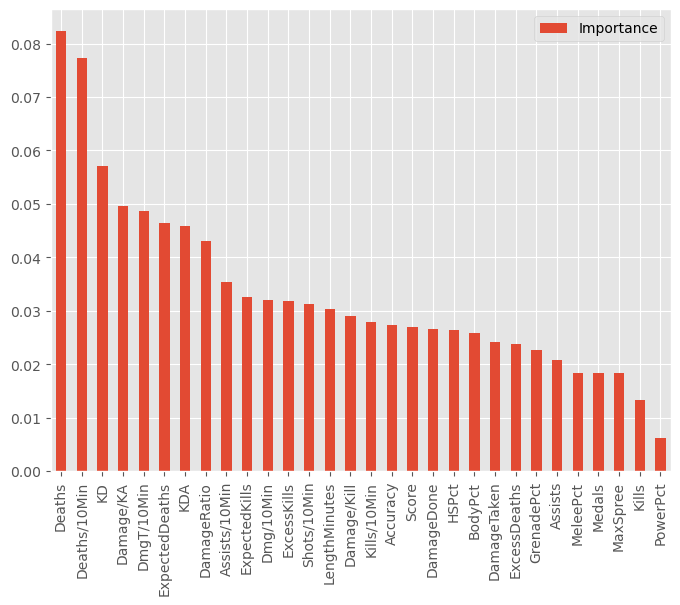

In [94]:
feat_importances = pd.DataFrame(rf_cv.best_estimator_.feature_importances_[:30], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

## Gradient Boosted Trees

In [95]:
# Gradient Boosted Trees
from sklearn.ensemble import GradientBoostingClassifier

param_grid_gbrt = {'n_estimators': [100,300,500],'learning_rate': [0.01,0.1],'max_depth': [2,4,6], 'subsample': [0.5,0.6,0.8,1]}
GBRT = GridSearchCV(estimator=GradientBoostingClassifier(random_state=69),
                    cv=5, param_grid=param_grid_gbrt,n_jobs=-1)
GBRT.fit(X_train_preprocessed, y_train)

print(GBRT.best_estimator_)
print(f'Gradient Boosed Trees Accuracy: {GBRT.score(X_test_preprocessed, y_test)}')
GBRT.cv_results_
paramResults(GBRT)

GradientBoostingClassifier(learning_rate=0.01, max_depth=4, random_state=69,
                           subsample=1)
Gradient Boosed Trees Accuracy: 0.7540983606557377
    learning_rate_param  max_depth_param  n_estimators_param  subsample_param  \
0                  0.01                2                 100              0.5   
1                  0.01                2                 100              0.6   
2                  0.01                2                 100              0.8   
3                  0.01                2                 100              1.0   
4                  0.01                2                 300              0.5   
..                  ...              ...                 ...              ...   
67                 0.10                6                 300              1.0   
68                 0.10                6                 500              0.5   
69                 0.10                6                 500              0.6   
70                 0.1

''

In [96]:
ResultsOut(GBRT)

Acc: 0.754
MAE: 0.25
MSE: 0.25
RMSE: 0.50
R^2 Score: 0.01
OOS R^2 Score: 0.01
Log Loss: 8.86
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.71      0.72        55
           1       0.77      0.79      0.78        67

    accuracy                           0.75       122
   macro avg       0.75      0.75      0.75       122
weighted avg       0.75      0.75      0.75       122

---------------------------------------------------------


''

<Axes: >

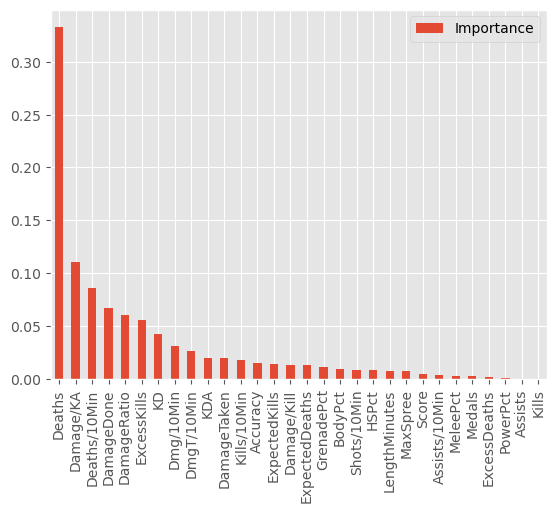

In [97]:
feat_importances = pd.DataFrame(GBRT.best_estimator_.feature_importances_[:30], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar')

## XGBoost

In [98]:
from xgboost import XGBClassifier

param_grid_xgb = {'n_estimators': [400,450,475,500],'learning_rate': [0.001,0.01,0.1,0.25],'max_depth': [1,2,3,4,5]}
XGB = GridSearchCV(estimator=XGBClassifier(random_state=69), cv=5, param_grid=param_grid_xgb,n_jobs=-1)
XGB.fit(X_train_preprocessed, y_train)

print(XGB.best_estimator_)
print(f'XGBoost Accuracy: {XGB.score(X_test_preprocessed, y_test)}')
paramResults(XGB)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=69, ...)
XGBoost Accuracy: 0.7704918032786885
    learning_rate_param  max_depth_param  n_estimators_param  Accuracy
0                 0.001                1                 400  0.652893
1                 0.001                1                 450  0.652893
2   

''

In [99]:
ResultsOut(XGB)

Acc: 0.770
MAE: 0.23
MSE: 0.23
RMSE: 0.48
R^2 Score: 0.07
OOS R^2 Score: 0.07
Log Loss: 8.27
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.73      0.74        55
           1       0.78      0.81      0.79        67

    accuracy                           0.77       122
   macro avg       0.77      0.77      0.77       122
weighted avg       0.77      0.77      0.77       122

---------------------------------------------------------


''

<Axes: >

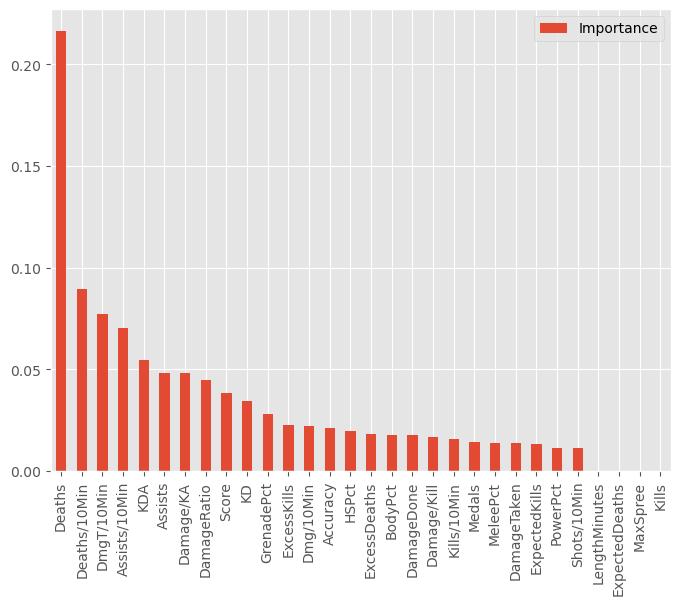

In [100]:
feat_importances = pd.DataFrame(XGB.best_estimator_.feature_importances_[:32], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

## Neural Net

In [101]:
from sklearn.neural_network import MLPClassifier

param_grid_nn = {'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver': ['lbfgs', 'sgd', 'adam'],
                'learning_rate': ['constant', 'invscaling', 'adaptive'], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
nn = GridSearchCV(estimator=MLPClassifier(random_state=61), cv=5, param_grid=param_grid_nn, n_jobs=-1)

nn.fit(X_train_preprocessed, y_train)
print(nn.best_estimator_)
print(f'Neural Net Accuracy: {nn.score(X_test_preprocessed, y_test)}')

/Users/aaronpalmer/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aaronpalmer/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aaronpalmer/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aaronpalmer/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aaron

MLPClassifier(activation='identity', alpha=0.1, random_state=61, solver='lbfgs')
Neural Net Accuracy: 0.8770491803278688


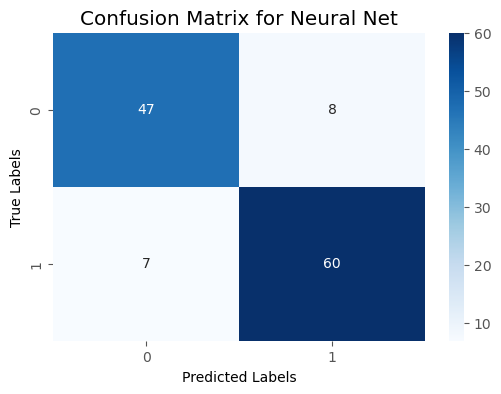

The confusion matrix shows the true positive, false negative, false positive, and true negative values, helping to evaluate the performance of a classification model.


<Axes: >

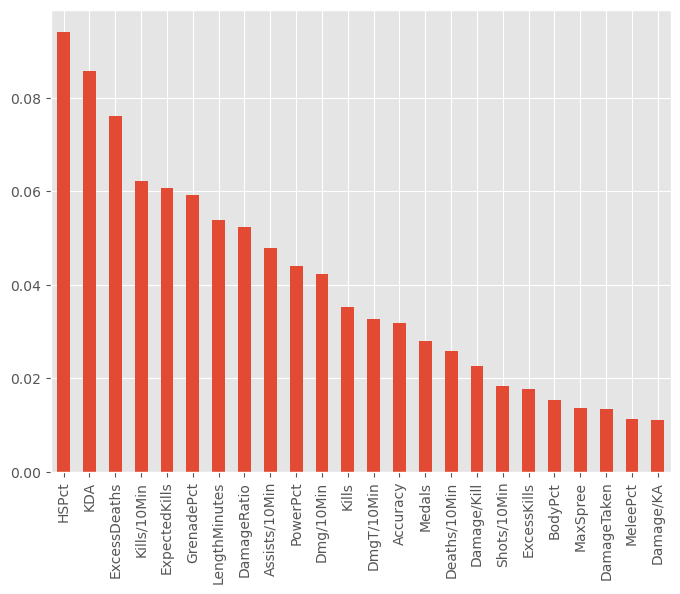

In [102]:
from sklearn.metrics import confusion_matrix
# Generate confusion matrix for the Neural Net
conf_matrix = confusion_matrix(y_test, nn.predict(X_test_preprocessed))
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Neural Net')
plt.show()

print("The confusion matrix shows the true positive, false negative, false positive, and true negative values, helping to evaluate the performance of a classification model.")
feat_importances_nn = pd.DataFrame(nn.best_estimator_.coefs_[0].flatten()[:30], index=X_train.columns, columns=["Importance"])
feat_importances_nn = feat_importances_nn.abs().sum(axis=1)
feat_importances_nn = feat_importances_nn / feat_importances_nn.sum()
feat_importances_nn = feat_importances_nn.sort_values(ascending=False)[:24]
feat_importances_nn.plot(kind='bar', figsize=(8,6))

## Keras NN

,Model,ACC,MAE,MSE,RMSE,R2,OOS R2,Log Loss
0,Logistic Regression,0.877,0.123,0.123,0.351,0.503,0.503,4.432
1,NeuralNet,0.877,0.123,0.123,0.351,0.503,0.503,4.432
2,Ridge,0.852,0.148,0.148,0.384,0.404,0.404,5.318
3,Lasso,0.852,0.148,0.148,0.384,0.404,0.404,5.318
4,ElasticNet,0.852,0.148,0.148,0.384,0.404,0.404,5.318
5,XGBoost,0.770,0.230,0.230,0.479,0.073,0.073,8.272
6,Gradient Boosted Trees,0.754,0.246,0.246,0.496,0.007,0.007,8.863
7,Random Forest,0.730,0.270,0.270,0.520,-0.093,-0.092,9.750
8,K-Nearest Neighbors,0.680,0.320,0.320,0.565,-0.291,-0.291,11.522


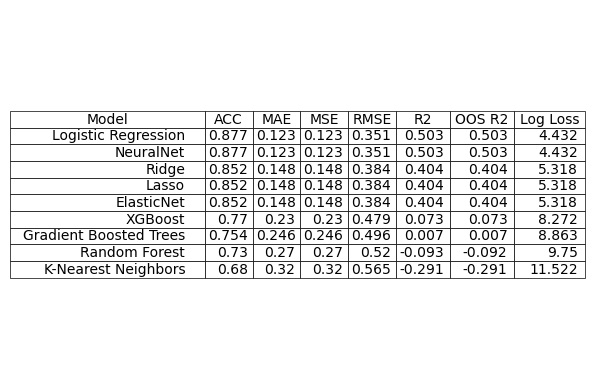

In [103]:
modelss = [logreg,ridge_cv,lasso_cv,elastic_cv,knn_cv,rf_cv,GBRT,XGB,nn]
model_namess = ['Logistic Regression', 'Ridge', 'Lasso', 'ElasticNet',
              'K-Nearest Neighbors', 'Random Forest', 'Gradient Boosted Trees', 'XGBoost', 'NeuralNet']
def saveResults(models, model_names):
    # Initialize an empty dataframe to store the metrics
    metrics_df = pd.DataFrame(columns=['Model', 'ACC' ,'MAE', 'MSE', 'RMSE', 'R2', 'OOS R2', 'Log Loss'])
    
    # Loop through each model and calculate the metrics
    for i, model in enumerate(models):
        # Generate predictions on the test set
        y_pred = model.predict(X_test_preprocessed)
        
        # Calculate regression metrics
        acc = round(model.score(X_test_preprocessed, y_test),3)
        mae = round(mean_absolute_error(y_test, y_pred),3)
        mse = round(mean_squared_error(y_test, y_pred),3)
        rmse = round(mean_squared_error(y_test, y_pred, squared=False),3)
        r2 = round(r2_score(y_test, y_pred),3)
        oosr2 = round(1-mean_squared_error(y_test,y_pred)/MSE_Histmean,3)
        ll = round(log_loss(y_test,y_pred),3)
        
        # Add metrics to the dataframe
        metrics_df.loc[i] = [model_names[i],acc, mae, mse, rmse, r2, oosr2, ll]
    
    metrics_df = metrics_df.sort_values('ACC', ascending=False).reset_index(drop=True)

    fig, ax = plt.subplots()
    table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns,
                     cellLoc='right', loc='center')
    table.auto_set_font_size(True)
    table.auto_set_column_width(col=list(range(len(metrics_df.columns))))
    ax.axis('off')
    plt.savefig('ModelResults0313.png', dpi=300, bbox_inches='tight')
    
    return metrics_df

saveResults(modelss,model_namess)


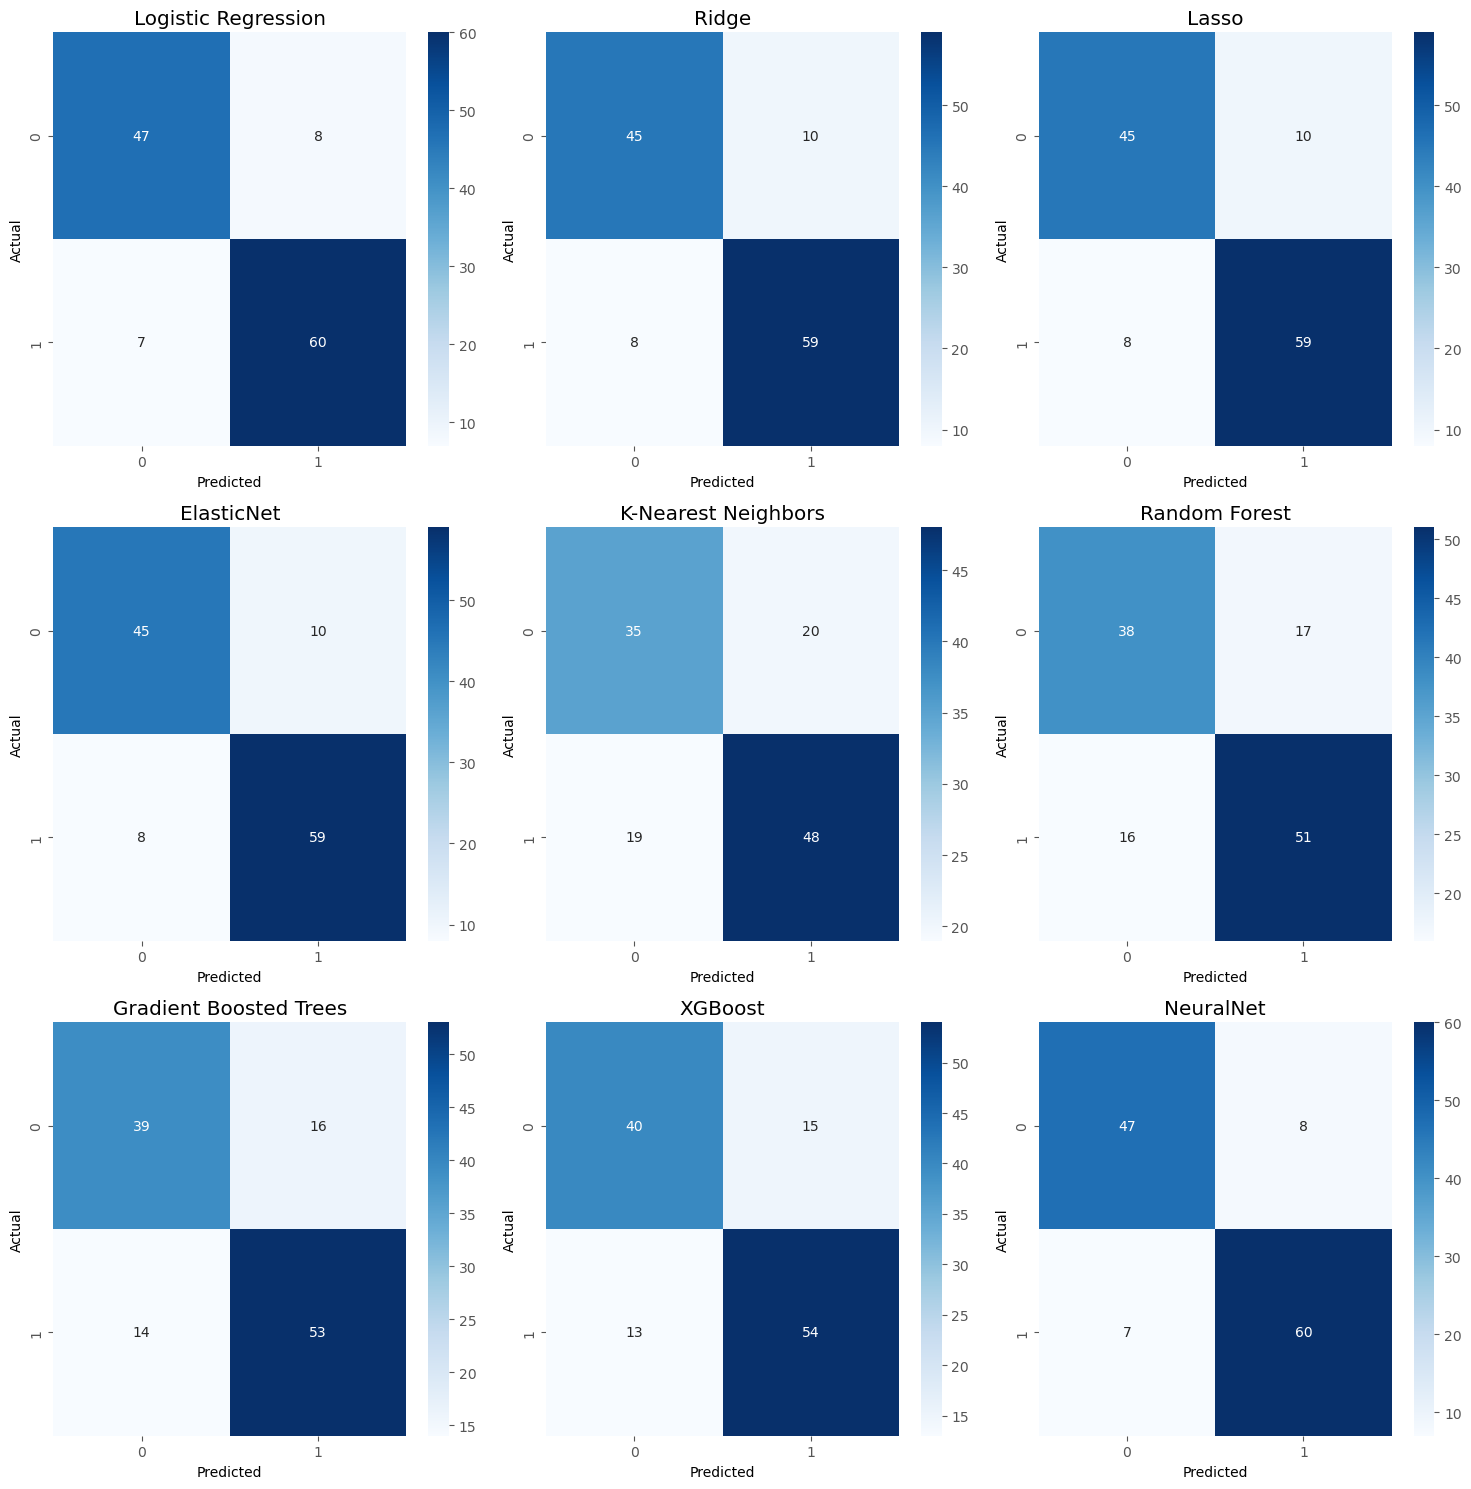

In [107]:
# Assuming X_test_preprocessed and y_test are your test data
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, (model, model_name) in enumerate(zip(modelss, model_namess)):
    y_pred = model.predict(X_test_preprocessed)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axs[i//3, i%3])
    axs[i//3, i%3].set_title(model_name)
    axs[i//3, i%3].set_xlabel('Predicted')
    axs[i//3, i%3].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('Plots/ConfusionMatrixMultigraph.png', dpi=300, bbox_inches='tight')
plt.show()

In [105]:
print(f'Runtime: {round(time.perf_counter() - start,2)}s')

Runtime: 130.66s


In [106]:
X_trainp_df = pd.DataFrame(X_train_preprocessed, columns=X_train.columns)
round(X_trainp_df.describe().transpose(),3).sort_values(by='max',ascending=False)

,count,mean,std,min,25%,50%,75%,max
DamageRatio,487.0,-0.0,1.001,-1.942,-0.710,-0.120,0.539,6.744
Damage/Kill,487.0,-0.0,1.001,-1.906,-0.666,-0.194,0.421,6.552
Shots/10Min,487.0,-0.0,1.001,-3.387,-0.580,0.014,0.552,6.043
PowerPct,487.0,-0.0,1.001,-0.360,-0.360,-0.360,-0.360,6.000
KD,487.0,-0.0,1.001,-1.545,-0.612,-0.206,0.320,5.995
Accuracy,487.0,-0.0,1.001,-2.842,-0.653,0.025,0.550,5.353
Damage/KA,487.0,0.0,1.001,-1.957,-0.657,-0.145,0.484,5.103
Score,487.0,0.0,1.001,-2.032,-0.776,-0.132,0.613,4.968
KDA,487.0,0.0,1.001,-2.583,-0.675,0.041,0.578,4.756
Medals,487.0,-0.0,1.001,-1.769,-0.659,-0.104,0.451,4.615
